In [1]:
# Imports
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler



In [2]:
# Load encoded dataset (must exist)
df = joblib.load('encoded.pkl')
print('Loaded encoded shape:', df.shape)
df.head()

Loaded encoded shape: (9320, 18)


,Vehicle Model,Battery Capacity (kWh),Charging Station Location,Energy Consumed (kWh),Charging Rate (kW),Charging Time Difference (minutes),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Energy per 100 km (kWh/100 km),Charging Cost (USD),Long Session
0,0,108.463007,0,60.712346,25.889181,39,0,0,29.371576,85.346739,293.602111,27.947953,2.0,0,0,20.678443,24.284938,0
1,1,100.000000,1,12.339275,30.677735,121,1,1,10.115778,22.455053,112.112804,14.311026,3.0,1,1,11.006125,1.604106,0
2,2,75.000000,1,19.128876,27.513593,168,1,2,6.854604,32.359772,71.799253,21.002002,2.0,2,0,26.642165,4.782219,1
3,1,50.000000,0,79.457824,22.382870,222,0,3,83.120003,100.000000,199.577785,38.316313,1.0,1,2,39.812960,10.329517,0
4,1,50.000000,2,19.629104,10.215712,106,1,3,54.258950,93.517158,203.661847,-7.834199,1.0,1,2,9.638086,2.551784,1


In [3]:
# Q-agent parameters (procedural, no def)
from sklearn.preprocessing import KBinsDiscretizer
n_actions = 4
n_bins = 8
lr = 0.2
gamma = 0.9
eps = 0.2
feature_names = []
discretizer = None
q_table = None

# helper lambdas (use after discretizer initialized)
state_to_idx = lambda arr: tuple(discretizer.transform(np.array(arr).reshape(1,-1)).astype(int)[0])
choose_action_proc = lambda s: (np.random.randint(n_actions) if np.random.rand() < eps else int(np.argmax(q_table[state_to_idx(s)])))
# q_table updates will be handled inline in the training cell

In [4]:
# MAB placeholders (procedural implementations will be in the training cell)
# We'll create counts/values arrays and alphas/betas in the training cell

eps_placeholder = 0.1
counts1 = None
values1 = None
counts2 = None
values2 = None
alphas3 = None
betas3 = None


In [5]:
# Define RL features and a simple single-step environment heuristic (procedural)
FEATURES = ['Charging Cost (USD)', 'Charging Time Difference (minutes)', 'State of Charge (Start %)', 'State of Charge (End %)']
X = df[FEATURES].fillna(0).values

# Initialize discretizer and q_table
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
discretizer.fit(X)
q_table = np.zeros(tuple([n_bins] * X.shape[1] + [n_actions]))

# Training loop (single-step episodes)
n_epochs = 5
for epoch in range(n_epochs):
    for x in X:
        s = x
        # choose action
        if np.random.rand() < eps:
            a = np.random.randint(n_actions)
        else:
            a = int(np.argmax(q_table[state_to_idx(s)]))
        # environment heuristic
        cost_v, time_v, soc_s, soc_e = s
        if a == 0:
            new_cost = cost_v
            new_time = time_v
        elif a == 1:
            new_cost = cost_v * 0.9
            new_time = time_v * 1.15
        elif a == 2:
            new_cost = cost_v * 0.95
            new_time = time_v * 0.95
        else:
            new_cost = cost_v * 0.92
            new_time = time_v * 1.05
        reward = - (0.7 * new_cost + 0.3 * new_time/60.0)
        s2 = np.array([new_cost, new_time, soc_s, soc_e])
        # update q_table (single-step → done=True)
        si = state_to_idx(s)
        sni = state_to_idx(s2)
        q = q_table[si + (a,)]
        target = reward
        q_table[si + (a,)] = q + lr * (target - q)

# Save trained agent artifacts (discretizer + q_table)
joblib.dump({ 'n_actions': n_actions, 'n_bins': n_bins, 'feature_names': FEATURES, 'lr': lr, 'gamma': gamma, 'eps': eps, 'discretizer': discretizer, 'q_table': q_table }, 'saved_models/rl_qagent.pkl')
print('Saved RL artifacts to saved_models/rl_qagent.pkl')

c:\Users\omar abuhassan\OneDrive\Desktop\Aply d\final\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\omar abuhassan\OneDrive\Desktop\Aply d\final\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


Saved RL artifacts to saved_models/rl_qagent.pkl


In [6]:
# Bandit 1: charger type (epsilon-greedy, procedural)
if 'Charger Type' in df.columns:
    arms1 = df['Charger Type'].unique().tolist()
else:
    arms1 = [0,1,2]
n1 = len(arms1)
eps1 = 0.1
counts1 = np.zeros(n1, dtype=int)
values1 = np.zeros(n1, dtype=float)

# reward: normalized inverse cost
costs = df['Charging Cost (USD)'].fillna(df['Charging Cost (USD)'].mean()).values
maxc = costs.max() if len(costs)>0 else 1.0
rewards = 1 - costs / (maxc + 1e-8)

if 'Charger Type' in df.columns:
    for idx, row in df.iterrows():
        arm = int(row['Charger Type'])
        counts1[arm] += 1
        n = counts1[arm]
        values1[arm] += (rewards[idx] - values1[arm]) / n

# Bandit 2: time-window proxy (UCB, procedural)
arms2 = [0,1,2]
n2 = len(arms2)
counts2 = np.zeros(n2, dtype=int)
values2 = np.zeros(n2, dtype=float)
t = 0
for i, val in enumerate(rewards):
    arm = i % n2
    t += 1
    counts2[arm] += 1
    n = counts2[arm]
    values2[arm] += (val - values2[arm]) / n

# Bandit 3: station groups (Thompson, procedural)
if 'Charging Station Location' in df.columns:
    arms3 = df['Charging Station Location'].unique().tolist()
else:
    arms3 = [0,1,2,3]
n3 = len(arms3)
alphas3 = np.ones(n3)
betas3 = np.ones(n3)
for idx, row in df.iterrows():
    arm = int(row.get('Charging Station Location', idx % n3))
    r = rewards[idx]
    alphas3[arm] += r
    betas3[arm] += (1 - r)

# Save bandit summaries as simple dicts
joblib.dump({'type':'eps','n_arms':n1,'eps':eps1,'counts':counts1,'values':values1}, 'saved_models/mab_charger_eps.pkl')
joblib.dump({'type':'ucb','n_arms':n2,'counts':counts2,'values':values2,'t':t}, 'saved_models/mab_time_ucb.pkl')
joblib.dump({'type':'thompson','n_arms':n3,'alphas':alphas3,'betas':betas3}, 'saved_models/mab_station_thompson.pkl')
print('Saved MAB artifacts to saved_models/')

Saved MAB artifacts to saved_models/


In [7]:
# Quick load checks


# Load and show a brief summary (procedural dicts)
rl_payload = joblib.load('saved_models/rl_qagent.pkl')
print('Loaded RL q_table shape:', rl_payload['q_table'].shape)
b1 = joblib.load('saved_models/mab_charger_eps.pkl')
print('Loaded MAB1 values (sample):', b1.get('values'))

Loaded RL q_table shape: (8, 8, 8, 8, 4)
Loaded MAB1 values (sample): [0.73472718 0.91483244 0.81911367]


## Visualisations: RL policy and MAB summaries

Features used for RL: ['Charging Cost (USD)', 'Charging Time Difference (minutes)', 'State of Charge (Start %)', 'State of Charge (End %)']


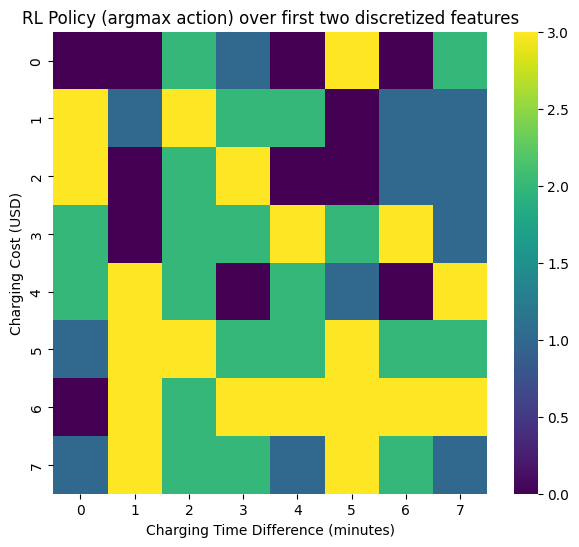

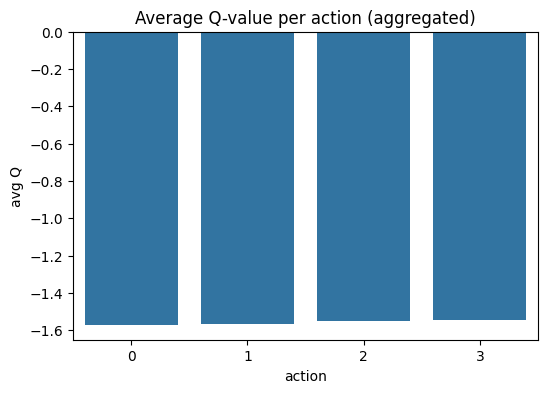

Sample state: [24.28493829 39.         29.37157598 85.34673948]
Recommended action: 0 expected Q: -13.007372721402048


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Load RL payload and MAB artifacts
rl = joblib.load('saved_models/rl_qagent.pkl')
q_table = rl['q_table']
discretizer = rl['discretizer']
FEATURES = rl.get('feature_names', ['f0','f1','f2','f3'])
print('Features used for RL:', FEATURES)
# Visualise policy over first two discretized dims
ndim = q_table.ndim - 1
if ndim < 2:
    print('Not enough state dims to plot policy heatmap.')
else:
    axes_to_mean = tuple(range(2, ndim)) if ndim > 2 else ()
    if axes_to_mean:
        q_agg = q_table.mean(axis=axes_to_mean)
    else:
        q_agg = q_table
    policy = np.argmax(q_agg, axis=-1)
    plt.figure(figsize=(7,6))
    sns.heatmap(policy, cmap='viridis', cbar=True, annot=False)
    plt.title('RL Policy (argmax action) over first two discretized features')
    plt.xlabel(FEATURES[1] if len(FEATURES)>1 else 'dim1')
    plt.ylabel(FEATURES[0] if len(FEATURES)>0 else 'dim0')
    plt.show()
    # Q-value per action aggregated
    qvals_mean = q_agg.mean(axis=(0,1)) if q_agg.ndim==3 else q_agg.mean(axis=0)
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(range(len(qvals_mean))), y=qvals_mean)
    plt.title('Average Q-value per action (aggregated)')
    plt.xlabel('action')
    plt.ylabel('avg Q')
    plt.show()

# Sample recommendation
sample = df[FEATURES].fillna(0).iloc[0].values
idx = tuple(discretizer.transform(sample.reshape(1,-1)).astype(int)[0])
action = int(np.argmax(q_table[idx]))
qval = float(np.max(q_table[idx]))
print('Sample state:', sample)
print('Recommended action:', action, 'expected Q:', qval)

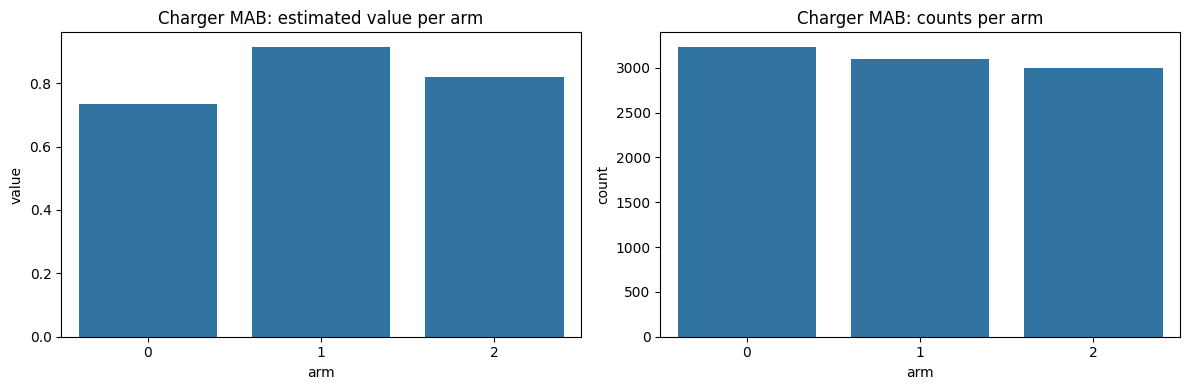

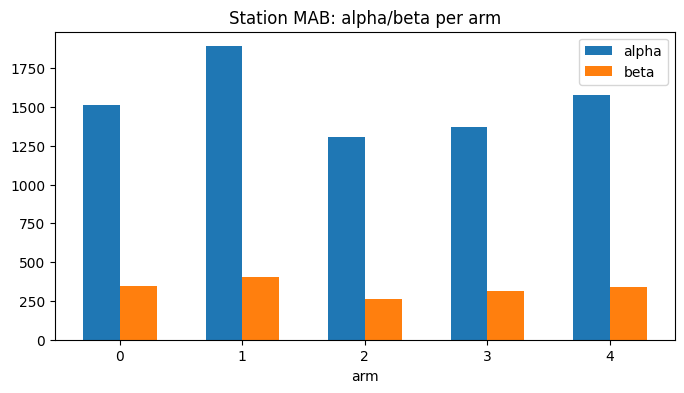

In [9]:
# Plot MAB summaries
b_charger = joblib.load('saved_models/mab_charger_eps.pkl')
b_time = joblib.load('saved_models/mab_time_ucb.pkl')
b_station = joblib.load('saved_models/mab_station_thompson.pkl')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
if b_charger.get('values') is not None:
    vals = b_charger['values']
    sns.barplot(x=list(range(len(vals))), y=vals)
    plt.title('Charger MAB: estimated value per arm')
    plt.xlabel('arm')
    plt.ylabel('value')
else:
    plt.text(0.5,0.5,'No values stored', ha='center')

plt.subplot(1,2,2)
if b_charger.get('counts') is not None:
    cnts = b_charger['counts']
    sns.barplot(x=list(range(len(cnts))), y=cnts)
    plt.title('Charger MAB: counts per arm')
    plt.xlabel('arm')
    plt.ylabel('count')
else:
    plt.text(0.5,0.5,'No counts stored', ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
if b_station.get('alphas') is not None:
    al = b_station['alphas']
    be = b_station['betas']
    x = np.arange(len(al))
    plt.bar(x-0.15, al, width=0.3, label='alpha')
    plt.bar(x+0.15, be, width=0.3, label='beta')
    plt.legend()
    plt.title('Station MAB: alpha/beta per arm')
    plt.xlabel('arm')
else:
    plt.text(0.5,0.5,'No alphas/betas stored', ha='center')
plt.show()